##Installation

In [1]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 34.7 MB/s 
     |████████████████████████████████| 596 kB 39.1 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 895 kB 28.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
MODEL_PATH = '/content/drive/MyDrive/NLP/NYT/best_rel_bert.pt'
DATA_LOADER_PATH = '/content/drive/MyDrive/NLP/NYT/'
DATASET_PATH = '/content/drive/MyDrive/NLP/NYT'
PRE_TRAINED_MODEL = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 32
# each epoch was executed separately due to google collab execution time constraints
EPOCHS = 1 
DROPOUT_PROBABILITY = 0.2
N_WARMUP_STEPS = 500
LEARNING_RATE = 2e-5
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
TOKENIZER.add_special_tokens({"additional_special_tokens": ["<e1>", "</e1>", "<e2>", "</e2>"]})

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

4

In [5]:
relations = pd.read_csv(f'{DATASET_PATH}/relations.txt', sep = "\t", header=None)
classes = {}
for i, r in enumerate(relations[0]):
  classes[r] = i
classes['other'] = 29

In [6]:
relations[0].tolist()

['/location/administrative_division/country',
 '/location/country/capital',
 '/location/country/administrative_divisions',
 '/location/neighborhood/neighborhood_of',
 '/location/location/contains',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/deceased_person/place_of_death',
 '/business/person/company',
 '/location/us_state/capital',
 '/people/person/place_of_birth',
 '/people/person/children',
 '/business/company/founders',
 '/business/company/place_founded',
 '/sports/sports_team/location',
 '/people/person/ethnicity',
 '/people/ethnicity/geographic_distribution',
 '/people/person/religion',
 '/business/company/major_shareholders',
 '/location/province/capital',
 '/location/br_state/capital',
 '/business/company/advisors',
 '/film/film_location/featured_in_films',
 '/film/film/featured_film_locations',
 '/location/us_county/county_seat',
 '/time/event/locations',
 '/people/deceased_person/place_of_burial',
 '/people/place_of_interment/interred_here',
 '/bus

# Preprocessing

In [7]:
def preprocess(text_data, entity_data):
  processed = []
  for i, t in enumerate(text_data[0]):
    entities = entity_data[0][i].split(" | ")
    entity_set = set()
    entity_label_map = {}
    for e in entities:
      vals = e.split(" ")
      e1_s = int(vals[0])
      e1_e = int(vals[1])
      e2_s = int(vals[2])
      e2_e = int(vals[3])
      entity_set.add((e1_s, e1_e))
      entity_set.add((e2_s, e2_e))
      entity_label_map.setdefault(((e1_s, e1_e), (e2_s, e2_e)), [])
      entity_label_map[((e1_s, e1_e), (e2_s, e2_e))].append(classes[vals[4]])

    # permute entity pairs and add to dataset
    for e1 in list(entity_set):
      for e2 in list(entity_set):
        if e1 != e2:
          words = t.strip().split(" ")
          if e1[1] < e2[0]:
            words = words[:e1[0]] + ["<e1>"] + words[e1[0]:e1[1]+1] + ["</e1>"] + words[e1[1]+1:e2[0]] + ["<e2>"] + words[e2[0]:e2[1]+1] + ["</e2>"] + words[e2[1]+1:]
          else:
            words = words[:e2[0]] + ["<e2>"] + words[e2[0]:e2[1]+1] + ["</e2>"] + words[e2[1]+1:e1[0]] + ["<e1>"] + words[e1[0]:e1[1]+1] + ["</e1>"] + words[e1[1]+1:]
          processed.append({'text': " ".join(words),
                                  'e1_start': e1[0],
                                  'e1_end': e1[1],
                                  'e2_start': e2[0],
                                  'e2_end': e2[1],
                                  'labels': entity_label_map.get((e1, e2), [29])})
  return pd.DataFrame(processed)


In [8]:
def convert_samples_to_features(
    samples,
    max_seq_len,
    tokenizer,
):
    features = []
    cls_token="[CLS]"
    sep_token="[SEP]"

    for (i, sample) in samples.iterrows():

        # tokenize
        tokens = tokenizer.tokenize(sample['text'])

        # find starting and ending index of entities
        e1_s = tokens.index("<e1>")  
        e1_e = tokens.index("</e1>")  
        e2_s = tokens.index("<e2>")  
        e2_e = tokens.index("</e2>")
        
        # ignore sample if ending index of entity is greated than max_length
        if e2_e >= max_seq_len - 1 or e1_e >= max_seq_len - 1:
          continue

        # replace token with $ and # signs
        tokens[e1_s] = "$"
        tokens[e1_e] = "$"
        tokens[e2_s] = "#"
        tokens[e2_e] = "#"
        
        # truncate
        if len(tokens) > max_seq_len - 2:
            tokens = tokens[: (max_seq_len - 2)]

        tokens += [sep_token]

        token_type_ids = [0] * len(tokens)

        tokens = [cls_token] + tokens
        token_type_ids = [0] + token_type_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        
        attention_mask = [1] * len(input_ids)

        # add zero padding
        padding_length = max_seq_len - len(input_ids)
        input_ids = input_ids + ([0] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)

        # create e1 and e2 mask
        e1_mask = [0] * len(attention_mask)
        e2_mask = [0] * len(attention_mask)

        for i in range(e1_s + 1, e1_e + 2):
            e1_mask[i] = 1
        for i in range(e2_s + 1, e2_e + 2):
            e2_mask[i] = 1
    
        label_ids = sample['labels']

        features.append({
                "input_ids":input_ids,
                "attention_mask":attention_mask,
                "token_type_ids":token_type_ids,
                "label_ids":label_ids,
                "e1_mask":e1_mask,
                "e2_mask":e2_mask,
            })

    return features

In [9]:
def convert_features_to_dataset(features):
  input_ids = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
  attention_mask = torch.tensor([f["attention_mask"] for f in features], dtype=torch.long)
  token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
  e1_mask = torch.tensor([f['e1_mask'] for f in features], dtype=torch.long)  # add e1 mask
  e2_mask = torch.tensor([f['e2_mask'] for f in features], dtype=torch.long)  # add e2 mask

  labels = []
  # convert label to one hot representation
  for f in features:
    label = [0]*30
    for i in f['label_ids']:
      label[i] = 1
    labels.append(label)
  label_ids = torch.tensor(labels)

  dataset = TensorDataset(
      input_ids,
      attention_mask,
      token_type_ids,
      e1_mask,
      e2_mask,
      label_ids,
  )
  return dataset

In [11]:
def save_data_loader(loader, loader_type):
  loader_path = f"{DATA_LOADER_PATH}{loader_type}.pt" 
  torch.save({'features': loader}, loader_path)

def load_data_loader(loader_type):
  state = None
  try:
    state = torch.load(f"{DATA_LOADER_PATH}{loader_type}.pt")
  except FileNotFoundError:
    pass
  if state:
    return state['features']
  return None

#### Load Data

In [12]:
train_data = pd.read_csv(f'{DATASET_PATH}/train.sent', sep = "\t", header=None)
train_data_loader = load_data_loader('train')
if not train_data_loader:
  train_entities = pd.read_csv(f'{DATASET_PATH}/train.pointer', sep = "\t", header=None)
  train_data = preprocess(train_data, train_entities)
  train_features = convert_samples_to_features(train_data, MAX_LENGTH, TOKENIZER)
  train_data_loader = DataLoader(dataset=convert_features_to_dataset(train_features), batch_size=BATCH_SIZE)
  save_data_loader(train_data_loader, 'train')

dev_data = pd.read_csv(f'{DATASET_PATH}/dev.sent', sep = "\t", header=None)
dev_data_loader = load_data_loader('dev')
if not dev_data_loader:
  dev_entities = pd.read_csv(f'{DATASET_PATH}/dev.pointer', sep = "\t", header=None)
  dev_data = preprocess(dev_data, dev_entities)
  dev_features = convert_samples_to_features(dev_data, MAX_LENGTH, TOKENIZER)
  dev_data_loader = DataLoader(dataset=convert_features_to_dataset(dev_features), batch_size=BATCH_SIZE)
  save_data_loader(dev_data_loader, 'dev')

test_data = pd.read_csv(f'{DATASET_PATH}/test.sent', sep = "\t", header=None)
test_data_loader = load_data_loader('test')
if not test_data_loader:
  test_entities = pd.read_csv(f'{DATASET_PATH}/test.pointer', sep = "\t", header=None)
  test_data = preprocess(test_data, test_entities)
  test_features = convert_samples_to_features(test_data, MAX_LENGTH, TOKENIZER)
  test_data_loader = DataLoader(dataset=convert_features_to_dataset(test_features), batch_size=BATCH_SIZE)
  save_data_loader(test_data_loader, 'test')

In [13]:
print("Raw dataset lengths:")
print(f"train - {len(train_data)}, dev - {len(dev_data)}, test - {len(test_data)}")
print("Pre processed dataset lengths:")
print(f"train - {len(train_data_loader) * BATCH_SIZE}, dev - {len(dev_data_loader) * BATCH_SIZE}, test - {len(test_data_loader) * BATCH_SIZE}")

Raw dataset lengths:
train - 63306, dev - 7033, test - 4006
Pre processed dataset lengths:
train - 146496, dev - 16352, test - 9408


####Classifier

In [14]:
class FCLayer(nn.Module):
  def __init__(self, input_dim, output_dim, dropout_rate=0.0, use_activation=True):
      super(FCLayer, self).__init__()
      self.use_activation = use_activation
      self.dropout = nn.Dropout(dropout_rate)
      self.linear = nn.Linear(input_dim, output_dim)
      self.sigmoid = nn.Sigmoid()
      self.tanh = nn.Tanh()
  def forward(self, x):
      x = self.dropout(x)
      x = self.linear(x)
      if self.use_activation:
        # used on intermediate layers
        x = self.tanh(x)
      else:
        # used for final layer
        x = self.sigmoid(x)
      return x


class RelationsBert(nn.Module):
  
  def __init__(self, num_classes):
    super(RelationsBert, self).__init__()
    # core bert model
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL)
    # drop out layer for bert output (for regularization)
    self.drop_out = nn.Dropout(p=DROPOUT_PROBABILITY)

    bert_size = self.bert.config.hidden_size
    self.fc_layer = FCLayer(bert_size, bert_size, DROPOUT_PROBABILITY)
    self.entity_fc_layer = FCLayer(bert_size, bert_size, DROPOUT_PROBABILITY)
    self.num_labels = num_classes
    self.label_classifier = FCLayer(
        bert_size * 3,
        num_classes,
        DROPOUT_PROBABILITY,
        use_activation=False,
    )
    
  def forward(self, input_ids, attention_mask, token_type_ids, labels, e1_mask, e2_mask):
    outputs = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
    sequence_output = outputs[0]
    pooled_output = outputs[1]
    
    # averaged entities
    e1_h = self.entity_average(sequence_output, e1_mask)
    e2_h = self.entity_average(sequence_output, e2_mask)

    # pass through fully connected layer
    pooled_output = self.fc_layer(pooled_output)
    e1_h = self.entity_fc_layer(e1_h)
    e2_h = self.entity_fc_layer(e2_h)

    # concatenate the 3 outputs
    concat_h = torch.cat([pooled_output, e1_h, e2_h], dim=-1)

    # final fully connected layer with sigmoid
    logits = self.label_classifier(concat_h)

    outputs = (logits,) + outputs[2:]
    
    # find loss
    loss_func = nn.BCELoss()
    loss = loss_func(logits.view(-1, self.num_labels), labels.float())

    outputs = (loss,) + outputs

    return outputs
  
  def entity_average(self, hidden_output, e_mask):
    e_mask_unsqueeze = e_mask.unsqueeze(1)  
    length_tensor = (e_mask != 0).sum(dim=1).unsqueeze(1)

    sum_vector = torch.bmm(e_mask_unsqueeze.float(), hidden_output).squeeze(1)
    avg_vector = sum_vector.float() / length_tensor.float()
    return avg_vector

####Training

In [15]:
def train_epoch(model, data_loader, scheduler, optimizer,
                device, n_samples):
  
  model = model.train()
  batch_count = 1
  loss_vals = []
  
  for d in data_loader:
    if batch_count % 500 == 0:
      print(f"Batch: {batch_count}/{len(data_loader)}")
    batch_count += 1
    input_ids = d[0].to(device)
    attention_mask = d[1].to(device)
    token_type_ids = d[2].to(device)
    e1_mask = d[3].to(device)
    e2_mask = d[4].to(device)
    labels = d[5].to(device)

    # set zero gradients
    optimizer.zero_grad()

    # train
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      labels=labels,
      e1_mask=e1_mask,
      e2_mask=e2_mask
    )
    
    # find loss
    loss = outputs[0]
    loss_vals.append(loss.item())
    if batch_count % 500 == 0:
      print (f'Training loss: {loss_vals[-1]}')

    loss.backward()

    # clip gradients to prevent from exploding gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
  
  return np.mean(loss_vals)
    

####Prediction

In [16]:
def predict(model, data_loader, device):
  model = model.eval()
  
  predictions = []
  targets = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d[0].to(device)
      attention_mask = d[1].to(device)
      token_type_ids = d[2].to(device)
      e1_mask = d[3].to(device)
      e2_mask = d[4].to(device)
      labels = d[5].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        labels=labels,
        e1_mask=e1_mask,
        e2_mask=e2_mask
      )

      predictions.extend(outputs[1])
      targets.extend(labels)

  return torch.stack(predictions).cpu(), torch.stack(targets).cpu()

#### Model Save/Load

In [17]:
def save_model():
  path = f"{MODEL_PATH}" 
  torch.save({'model': model.state_dict()}, path)

def load_model():
  state = None
  try:
    state = torch.load(f'{MODEL_PATH}')
  except FileNotFoundError:
    pass
  if state:
    model.load_state_dict(state['model'])

####Driver Code

In [18]:
# Initialize Classifier model
model = RelationsBert(len(classes))
model = model.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=N_WARMUP_STEPS,
  num_training_steps=total_steps
)

load_model()
print(f"Total train batches: {len(train_data_loader)}")

# Training loop
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}:')
  
  loss = train_epoch(model, train_data_loader, scheduler, optimizer, device, len(train_data))
  print(f'Training loss {loss}')

save_model()
  


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train batches: 4578
Epoch 1/1:
Training loss: 0.023425227031111717
Batch: 500/4578
Training loss: 0.0022069381084293127
Batch: 1000/4578
Training loss: 0.016091329976916313
Batch: 1500/4578
Training loss: 0.0028149124700576067
Batch: 2000/4578
Training loss: 0.009956803172826767
Batch: 2500/4578
Training loss: 0.007720405701547861
Batch: 3000/4578
Training loss: 0.01957617700099945
Batch: 3500/4578
Training loss: 0.011288691312074661
Batch: 4000/4578
Training loss: 0.006367669440805912
Batch: 4500/4578
Training loss 0.009370133309991424


##Results

In [21]:
def process_result(preds, labels, threshold):
  y_pred, y_true = [], []
  for i in range(len(labels)):
    if labels[i][29] == 1:
        continue
    args = [1 if preds[i][k] >= threshold else 0 for k in range(len(preds[i])) ]
    y_pred.append(args)
    y_true.append(labels[i].cpu().tolist())
  return y_pred, y_true

##Training Set

In [20]:
preds, labels = predict(model, train_data_loader, device)

In [21]:
y_pred, y_true = process_result(preds, labels, 0.5)
print(classification_report(y_true,y_pred, labels=[i for i in range(29)], target_names=relations[0].tolist()))

                                             precision    recall  f1-score   support

  /location/administrative_division/country       1.00      1.00      1.00      5768
                  /location/country/capital       1.00      1.00      1.00      6679
 /location/country/administrative_divisions       0.99      1.00      0.99      5768
     /location/neighborhood/neighborhood_of       1.00      0.99      0.99      5181
                /location/location/contains       1.00      1.00      1.00     26535
                 /people/person/nationality       0.99      0.99      0.99      8095
                 /people/person/place_lived       0.89      0.93      0.91      6872
     /people/deceased_person/place_of_death       0.85      0.59      0.70      1853
                   /business/person/company       1.00      0.99      0.99      5343
                 /location/us_state/capital       0.96      1.00      0.98       631
              /people/person/place_of_birth       0.78      0.52

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####Validation Set

In [24]:
preds_1, labels_1 = predict(model, dev_data_loader, device)
y_pred, y_true = process_result(preds_1, labels_1, 0.5)
print(classification_report(y_true, y_pred, labels=[i for i in range(29)], target_names=relations[0].tolist()))

                                             precision    recall  f1-score   support

  /location/administrative_division/country       1.00      0.99      0.99       632
                  /location/country/capital       0.99      1.00      0.99       738
 /location/country/administrative_divisions       0.98      0.99      0.98       632
     /location/neighborhood/neighborhood_of       1.00      0.98      0.99       549
                /location/location/contains       1.00      0.99      0.99      3063
                 /people/person/nationality       0.99      0.99      0.99       935
                 /people/person/place_lived       0.87      0.91      0.89       762
     /people/deceased_person/place_of_death       0.80      0.59      0.68       191
                   /business/person/company       1.00      0.98      0.99       560
                 /location/us_state/capital       0.97      1.00      0.98        65
              /people/person/place_of_birth       0.72      0.45

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Testing Set

In [25]:
preds_2, labels_2 = predict(model, test_data_loader, device)
y_pred, y_true = process_result(preds_2, labels_2, 0.5)
print(classification_report(y_true, y_pred, labels=[i for i in range(29)], target_names=relations[0].tolist()))

                                             precision    recall  f1-score   support

  /location/administrative_division/country       0.99      0.97      0.98       379
                  /location/country/capital       0.99      1.00      0.99       485
 /location/country/administrative_divisions       0.94      0.97      0.95       379
     /location/neighborhood/neighborhood_of       1.00      0.97      0.98        65
                /location/location/contains       1.00      0.74      0.85      2515
                 /people/person/nationality       0.99      1.00      0.99       668
                 /people/person/place_lived       0.90      0.95      0.92       427
     /people/deceased_person/place_of_death       0.55      0.29      0.38        62
                   /business/person/company       1.00      0.98      0.99       285
                 /location/us_state/capital       0.00      0.00      0.00        37
              /people/person/place_of_birth       0.71      0.41

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Threshold tuning

In [22]:
f_scores = []
for th in range(1, 10):
  y_pred, y_true = process_result(preds, labels, th/10)
  precision,recall,fscore,support=score(y_true,y_pred,average='micro', labels=[i for i in range(29)])
  f_scores.append(fscore)

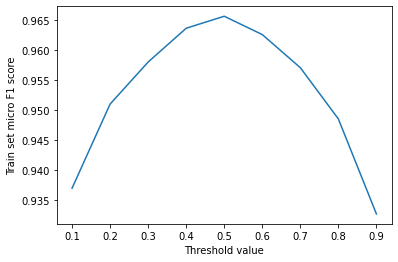

In [23]:
xaxis = np.array([i for i in range(1, 10)]) * 0.1
yaxis = np.array(f_scores)
plt.plot(xaxis, yaxis)
plt.xlabel("Threshold value")
plt.ylabel("Train set micro F1 score")
plt.show()